# Final Project: SLAM from Video


#### Required packages

In [25]:
# Import required libraries here
import cv2                               # OpenCV
import numpy as np                       # numpy
import os
from pupil_apriltags import Detector
import requests
import pickle
import glob   # filename and path management for file I/O

import plotly.express as px
import plotly.graph_objects as go

from utils import *

# Use this line to make matplotlib plot inline (only need to call it once when importing matplotlib)
%matplotlib inline

import matplotlib.pyplot as plt
# Modify this line to adjust the displayed plot size. You can also call
# it with different parameters or use plt.figure(figsize=[H, W]) before specific plots.
plt.rcParams['figure.figsize'] = [10, 10]

#### Required data files

In [26]:
! unzip -n ./SLAM_videos.zip

Archive:  ./SLAM_videos.zip
  inflating: AprilBoards.pickle      
  inflating: table_calib.MOV         
  inflating: table_fish.MOV          


In [27]:
data = pickle.load(open('./AprilBoards.pickle', 'rb'))
at_coarseboard = data['at_coarseboard']
at_fineboard = data['at_fineboard']
at_detector = Detector(families='tag36h11',
                       nthreads=1,
                       quad_decimate=1.0,
                       quad_sigma=0.0,
                       refine_edges=1,
                       decode_sharpening=0.25,
                       debug=0)

In [4]:
cal_src = './table_calib.MOV'
fish_src = './table_fish.MOV'

cal_video = processVideo(cal_src)
fish_video = processVideoRGB(fish_src)

0 226: 80 imgpts, 80 objpts
1 165: 80 imgpts, 80 objpts
2 122: 80 imgpts, 80 objpts
3 164: 80 imgpts, 80 objpts
4 59: 80 imgpts, 80 objpts
5 148: 80 imgpts, 80 objpts
6 108: 80 imgpts, 80 objpts
7 196: 80 imgpts, 80 objpts
8 29: 80 imgpts, 80 objpts
9 173: 80 imgpts, 80 objpts
10 21: 80 imgpts, 80 objpts
11 73: 80 imgpts, 80 objpts
12 154: 80 imgpts, 80 objpts
13 176: 80 imgpts, 80 objpts
14 104: 80 imgpts, 80 objpts
15 194: 80 imgpts, 80 objpts
16 166: 80 imgpts, 80 objpts
17 201: 80 imgpts, 80 objpts
18 217: 80 imgpts, 80 objpts
19 31: 80 imgpts, 80 objpts


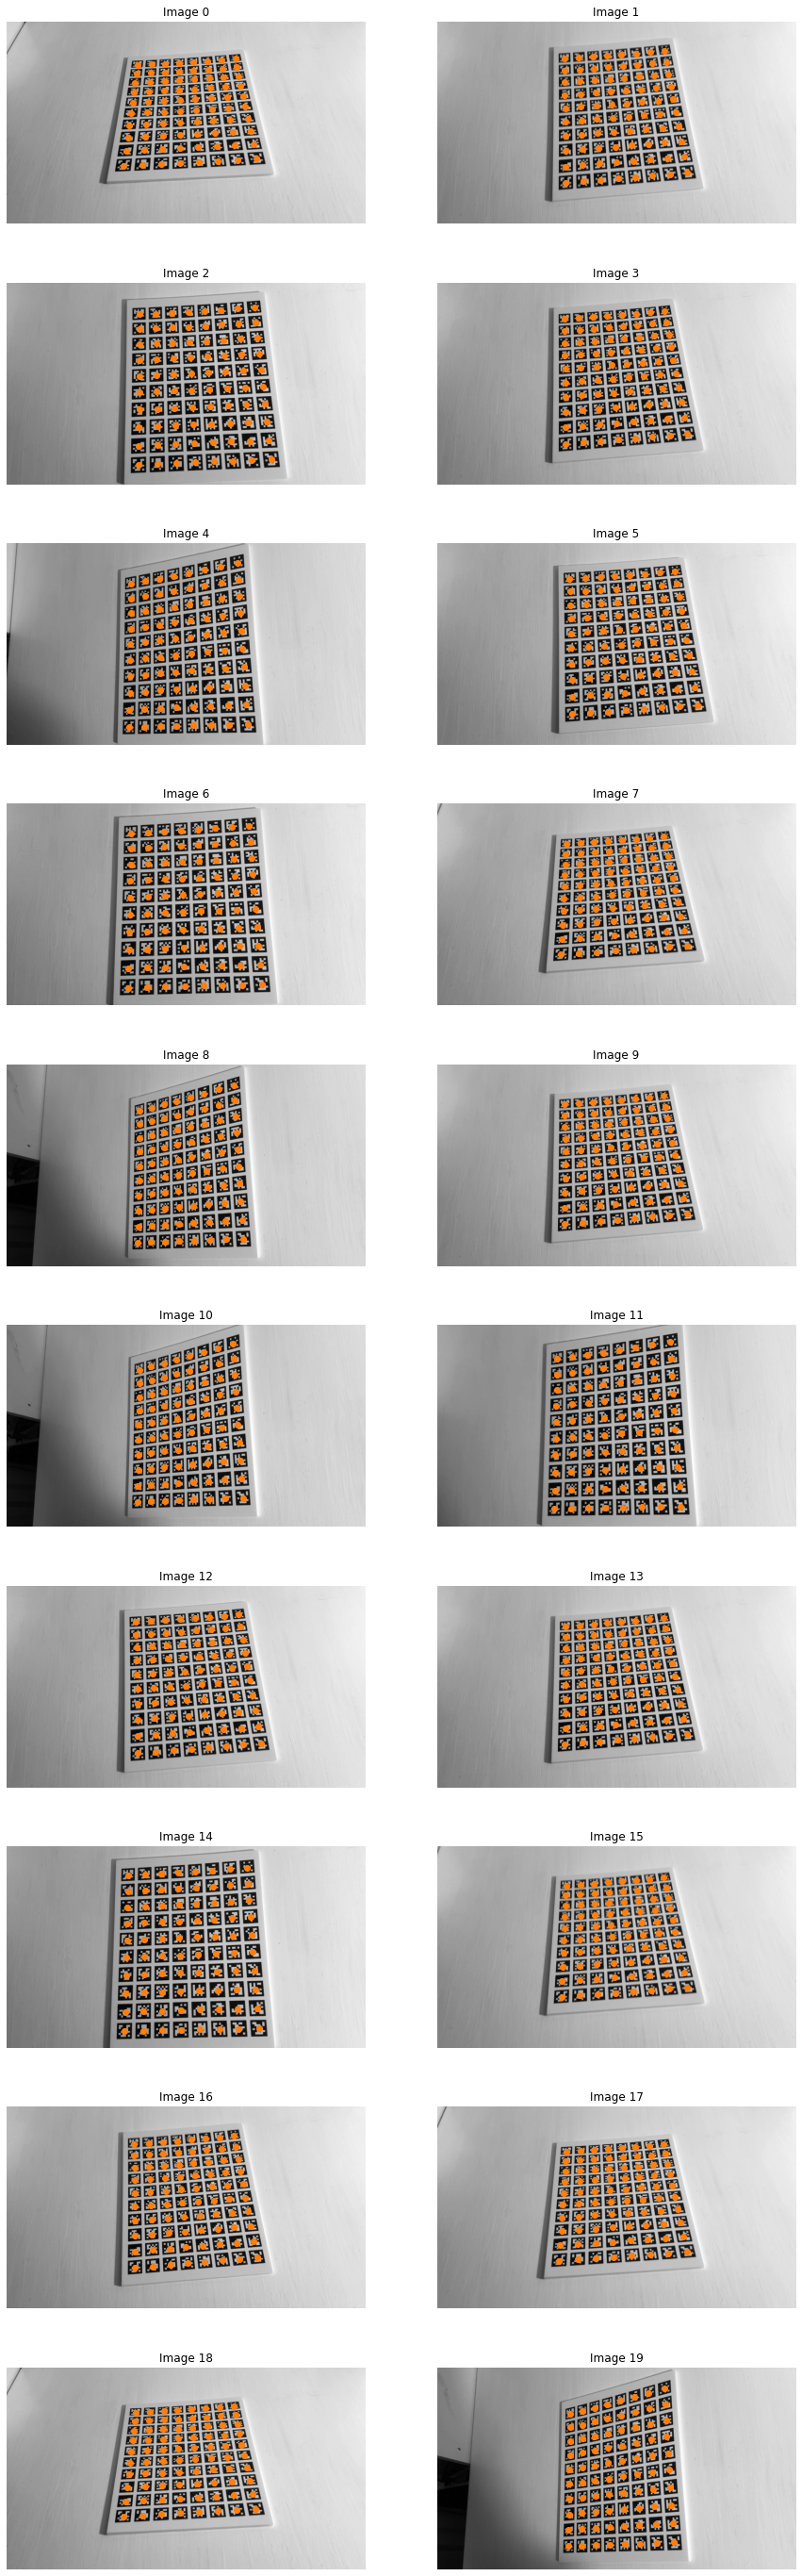

RMSE of reprojected points: 0.23666317005516466
Distortion coefficients: [[ 3.12191576e-01 -1.98924738e+00 -1.97538993e-02 -4.15783631e-03
   6.18130183e+00]]
Intrinsic camera matrix [[909.00130112   0.         468.32094283]
 [  0.         911.55432875 233.24377908]
 [  0.           0.           1.        ]]


In [5]:
reprojerr, calMatrix, distCoeffs, calRotations, calTranslations = calibrateCamera(cal_video, at_fineboard, debug=True)

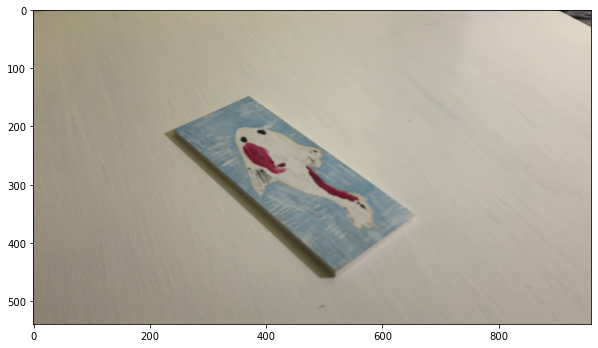

In [6]:
imgs = []
for i in range(fish_video[0].shape[2]):
    rgb_img = np.zeros((540, 960, 3))
    rgb_img[:, :, 0] = fish_video[0][:, :, i]
    rgb_img[:, :, 1] = fish_video[1][:, :, i]
    rgb_img[:, :, 2] = fish_video[2][:, :, i]
    rgb_img = np.uint8(rgb_img)
    imgs.append(rgb_img)

plt.imshow(imgs[0])

In [7]:
print(calMatrix)

[[909.00130112   0.         468.32094283]
 [  0.         911.55432875 233.24377908]
 [  0.           0.           1.        ]]


## Familiar helper functions

* `in2hom(X)`: Convert $N\times m$ inhomogeneous to $N\times (m+1)$ homogeneous coordinates for $N>1$
* `hom2him(X)`: Convert $N\times m$ homogeneous to $N\times (m-1)$ inhomogeneous coordinates for $N>1$
* `plotimageline(h,w,line,ax)`: Add line to matplotlib figure
* `plotcamera(h,w,camera,raysize,figobj)`: Add tetrahedral camera to pyplot figure

In [8]:
# Convert from Nxm inhomogeneous to Nx(m+1) homogeneous coordinates
def in2hom(X):
    return np.concatenate([X, np.ones((X.shape[0], 1), dtype=np.float32)], axis=1)

# Convert from Nxm homogeneous to Nx(m-1) inhomogeneous coordinates
def hom2in(X):
    return X[:, :-1] / X[:, -1:]

def plotimageline(h,w,line,ax):
# Add image line to matplotlib figure
# Input:
#   h,w -- height and width of image (in pixels)
#   l  -- 3-vector of line coordinates (a,b,c)
#   ax -- plt.axes object 
#
# Returns: 1

    x,y=np.meshgrid(np.linspace(0,w,w*2),np.linspace(0,h,h*2))
    ax.contour(x, y, line[0]*x+line[1]*y+line[2], [0], colors='r')

    return 1

def plotcamera(h,w,camera,raysize,figobj):
# Add tetrahedral camera to pyplot figure
# Input:
#   h,w --     height and width of image in pixels
#   camera --  3x4 camera matrix
#   raysize -- length of tetrahedral edges (in world units)
#   fig --     pyplot figure object
#
# Returns: 1
#
# Uses anatomy of camera matrices from Hartley and Zisserman Chapter 6

    # normalize camera such that bottom-left three-vector 
    #   corresponds to unit-length principal ray in front of camera (HZ Section 6.2.3)
    camera=camera*np.sign(np.linalg.det(camera[:,0:3]))/np.linalg.norm(camera[2,0:3])
    
    # Compute camera center (null vector of P)
    _, _, v = np.linalg.svd(camera)
    C = np.transpose(v[-1,0:3]) / v[-1,3]

    # Back-project image corners to unit-length 3D ray segments:
    S = np.array([[0, 0, 1],       # homog image coords if top left pixel
                  [0, h-1, 1],     # bottom left 
                  [w-1, h-1, 1],   # bottom right
                  [w, 0, 1]])      # top right
    
    #   HZ equation (6.14): compute one 3D point along each ray
    X = np.transpose(np.linalg.lstsq(
        camera[:,0:3], 
        np.transpose(S)-np.expand_dims(camera[:,3],axis=1), 
        rcond=None)[0])
    
    #   unit-vectors from camera center to each 3D point
    V = X - np.tile(C, (4, 1))
    V = V / np.linalg.norm(V, ord=2, axis=1, keepdims=True)
    
    # make sure these vectors point forwards from the camera instead of backwards
    V = V*np.expand_dims(np.sign(np.sum(V * np.tile(camera[2,0:3],(4, 1)), axis=1)),axis=1)
    
    #   desired ray segments that are length raysize in these directions 
    V = np.tile(C, (4, 1)) + raysize * V
    
    # append the camera center itself to complete the four tetrahedral vertices
    V=np.vstack([C,V])

    # add camera center to figure
    figobj.add_trace(go.Scatter3d(
        x=[C[0]], 
        y=[C[1]],
        z=[C[2]],
        mode='markers',
        marker=dict(
            size=3,
            color='#ff7f0e'
        )
    )
                    )


    # add tetrahedron to figure
    figobj.add_trace(go.Mesh3d(
        # vertices of tetrahedron
        x=V[:,0],
        y=V[:,1],
        z=V[:,2],

        # i, j and k give the vertices of triangles
        i=[0, 0, 0, 0],
        j=[1, 2, 3, 4],
        k=[2, 3, 4, 1],
        opacity=0.5,
        color='#ff7f0e'
    ))
   
    return 1

## New helper functions
* `getSIFT(imgs)`: Returns a list of the keypoints and descriptors for a list of images `imgs`.
* `getMatches(kp1, des1, kp2, des2, MATCH_PERCENT)`: Returns the inlier points for matches between two iamges with the provided keypoints and descriptors.
* `getProjMatrix(R, t, calMatrix)`: Returns the projection matrix given a rotation, translation, and the intrinsic camera matrix.
* `triangulate(pts1,pts2, calMatrix)`: Returns triangulated point coordinates and the two projection matrices, as well as the relative translation. Uses built-in OpenCV functions.
* `showPlot(ptsList, camList, plane=None)`: Shows the plotly 3D representation of the cameras as well as the triangulated feature points (the points shown were the points triangulated only for the first and second frame to avoid cluttering). 
* `plane_fit_ransac(points, iterations = 400, INLIER_THRESH = .1)`: Finds best plane fit for given 3D points and returns the plane equation for the best consensus set after running a RANSAC algorithm.
* `project_points(points, plane)`: Projects `points` onto `plane` and returns the new coordinates of the projected points.

In [9]:
def getSIFT(imgs):
    kps = []
    dess = []
    sift = cv2.SIFT_create()
    
    for img in imgs:
        kp, des = sift.detectAndCompute(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), None)
        kps.append(kp)
        dess.append(des)
    return kps, dess

def getMatches(kp1, des1, kp2, des2, MATCH_PERCENT=1):
    # Create a "brute force" matcher object using the L2 norm,
    #  and using "cross check" to only keep symmetric matches
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

    # Find matches between images 1->2 and images 3->2
    matches12 = bf.match(des1, des2)

    # Sort matches in the order of increasing match-distance; keep top ones
    matches12 = sorted(matches12, key = lambda x:x.distance)
    numGoodMatches = int(len(matches12) * MATCH_PERCENT)
    matches12 = matches12[:numGoodMatches]

    # Get pixel coordinates of the surving matches
    X1 = np.array([kp1[match.queryIdx].pt for match in matches12])
    X2 = np.array([kp2[match.trainIdx].pt for match in matches12])
    
    # compute fundamental matrix
    F, mask = cv2.findFundamentalMat(X1, X2, cv2.FM_RANSAC, 0.2)

    # Subset of points that are inliers
    X1in = X1[mask.ravel()==1]
    X2in = X2[mask.ravel()==1]

    return X1in, X2in

def getProjMatrix(R, t, calMatrix):
    M = np.concatenate((R,t),axis=1)
    return np.dot(calMatrix, M)

def triangulate(pts1,pts2, calMatrix):       
    # using the essential matrix can get you the rotation/translation bet. cameras, although there are two possible rotations: 
    E,_ = cv2.findEssentialMat(pts1, pts2, calMatrix, cv2.RANSAC, 0.999, 0.5)

    _, R, t,_ = cv2.recoverPose(E,pts1, pts2, calMatrix,0.5)

    # given R,t you can  explicitly find 3d locations using projection 
    proj_r = getProjMatrix(R, t, calMatrix)
    proj_l = getProjMatrix(np.eye(3), np.zeros((3,1)), calMatrix)
    points_4d_hom = cv2.triangulatePoints(proj_l, proj_r, np.expand_dims(pts1, axis=1), np.expand_dims(pts2, axis=1))
    points_3d = hom2in(points_4d_hom.T)
    return points_3d, proj_l, proj_r, R, t

def showPlot(ptsList, camList, plane=None):
    fig = go.Figure()
    for pts in ptsList:
        fig.add_trace(go.Scatter3d(x=pts[:,0], 
                                   y=pts[:,1],
                                   z=pts[:,2],
                                   mode='markers',
                                   marker=dict(
                                       size=2,
                                       color='#1f77b4'
                                   )
                                  ))

    # add cameras
    for cam in camList:
        plotcamera(h,w,cam,1,fig)

    # adjust plotly figure: aspect ratio and initial viewing direction
    fig.update_layout(scene_aspectmode='manual',
                      scene_aspectratio=dict(x=1, y=1, z=1),
                      showlegend=False,
                      scene_camera=dict(
                          up=dict(x=0, y=-1, z=0),
                          center=dict(x=0, y=0, z=0),
                          eye=dict(x=0, y=-.5, z=-2)
                      )
                      )
    
    if plane is not None:
        X_mesh, Y_mesh, Z_mesh = np.mgrid[-10:10, -10:10, 0:20]  

        fitted_plane_meshed = X_mesh*plane[0] + Y_mesh*plane[1] + Z_mesh*plane[2] + plane[3]
        fig.add_trace(go.Isosurface(
            x=X_mesh.flatten(),
            y=Y_mesh.flatten(),
            z=Z_mesh.flatten(),
            value= fitted_plane_meshed.flatten(),
            isomin=0,
            isomax=0,
            opacity=0.3,
            colorscale='blues',
            showscale=False, # remove colorbar
            ))
        

    fig.show()

def plane_fit_ransac(points, iterations = 400, INLIER_THRESH = .1):
    x = points[:, 0]
    y = points[:, 1]
    z = points[:, 2]
    best_consensus_set = np.zeros((0,))
    numpts = x.size
    best_plane = None
    
    # try a bunch of different planes
    for _ in range(iterations):
        # Randomly sample three distinct points
        sample_inds = np.random.choice(numpts, size=3, replace=False)
        xs = x[sample_inds]
        ys = y[sample_inds]
        zs = z[sample_inds]

        # Make homogeneous
        p1 = np.array([xs[0], ys[0], zs[0], 1], dtype=np.float32)
        p2 = np.array([xs[1], ys[1], zs[1], 1], dtype=np.float32)
        p3 = np.array([xs[2], ys[2], zs[2], 1], dtype=np.float32)

        # Get plane determined by these three points
        A = np.vstack([p1, p2, p3])
        u,s,vt = np.linalg.svd(A)
        plane = vt[-1,:]

        # store perpendicular distance from plane to every pt in dist array
        dist = np.abs(x * plane[0] + y * plane[1] + z * plane[2] + plane[3]) / np.sqrt(plane[0] ** 2 + plane[1] ** 2 + plane[2] ** 2)

        # Find consensus set (tuple of indices within x (and y))
        consensus_set = np.nonzero(dist < INLIER_THRESH)[0]

        # If it is larger than the best one so far, keep it
        if consensus_set.size >= best_consensus_set.size:
            best_consensus_set = consensus_set
            best_plane = plane

    # inliers for best line
    xc = x[best_consensus_set]
    yc = y[best_consensus_set]
    zc = z[best_consensus_set]
        
    return best_plane, best_consensus_set

def project_points(points, plane):
    plane = plane/(-plane[3])
    a = plane[0]
    b = plane[1]
    c = plane[2]
    vector_norm = a*a + b*b + c*c
    normal_vector = np.array([a, b, c]) / np.sqrt(vector_norm)
    point_in_plane = np.array([a, b, c]) / vector_norm

    points_from_point_in_plane = points - point_in_plane
    proj_onto_normal_vector = np.dot(points_from_point_in_plane,
                                     normal_vector)
    proj_onto_plane = (points_from_point_in_plane -
                       proj_onto_normal_vector[:, None]*normal_vector)

    return point_in_plane + proj_onto_plane

    

## Output first two frames
In order to be able to triangulate, instead of using each consecutive frame, we use every 30th frame.

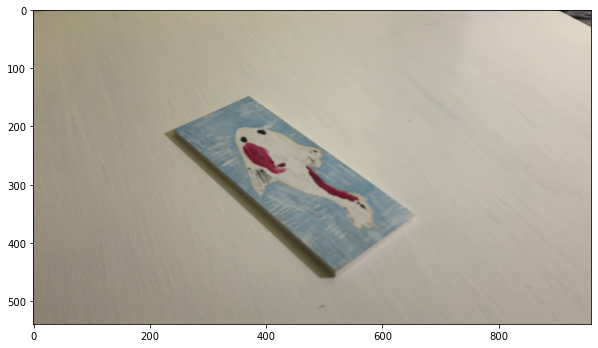

In [10]:
im1 = imgs[0]
im2 = imgs[30]
plt.imshow(im1)

h,w,_=im2.shape

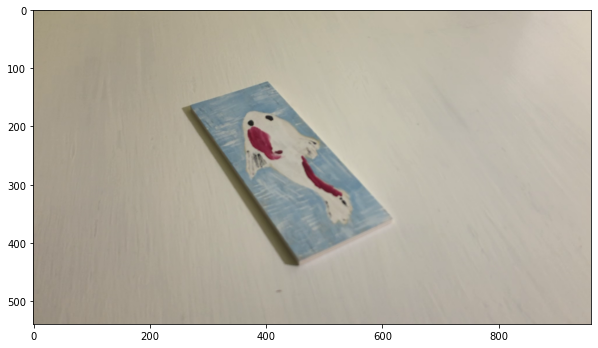

In [11]:
plt.imshow(im2)

## Detect and triangulate using OpenCV for two frames


In [12]:
kp_, des_ = getSIFT([im1, im2])

In [13]:
X1in, X2in = getMatches(kp_[0], des_[0], kp_[1], des_[1], MATCH_PERCENT=1)
points3D, P1, P2, _, _ = triangulate(X1in, X2in, calMatrix)
plane, consensus_set = plane_fit_ransac(points3D)

In [14]:
showPlot([points3D], [P1, P2], plane)

## Visualize plane and points for base of pyramid

In [15]:
plane_pts = []
pt_sum = np.zeros((1, 3))

for num in consensus_set:
    pt = points3D[num]
    plane_pts.append(pt)
    pt_sum = pt_sum + pt

pt_sum = pt_sum/len(consensus_set)
    
plane_pts = np.asarray(plane_pts)
    
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=plane_pts[:,0], 
                           y=plane_pts[:,1],
                           z=plane_pts[:,2],
                           mode='markers',
                           marker=dict(
                               size=2,
                               color='blue'
                           )
                          ))
fig.add_trace(go.Scatter3d(x=pt_sum[:,0], 
                           y=pt_sum[:,1],
                           z=pt_sum[:,2],
                           mode='markers',
                           marker=dict(
                               size=2,
                               color='red'
                           )
                          ))

pt_sum = project_points(pt_sum, plane)

# MAKE SQUARE TO BE THE BASE OF THE PYRAMID
a = plane[0]
b = plane[1]
c = plane[2]
d = plane[3]
avg_pt = pt_sum[0]
x_pt = avg_pt[0] + 0.5
y_pt = avg_pt[1] + 0.5
sq_z = -(a*x_pt + b*y_pt + d)/c
sq1 = avg_pt
sq2 = np.array([x_pt, y_pt, sq_z])
vec = pt_sum - sq2
dist = np.linalg.norm(vec)
norm = np.cross(np.array([a, b, c]), vec)
norm = norm / np.linalg.norm(norm)
sq3 = sq2 + norm*dist
sq4 = sq3 + vec
sq = np.vstack((sq1, sq2, sq3, sq4))

fig.add_trace(go.Scatter3d(x=sq[:,0], 
                           y=sq[:,1],
                           z=sq[:,2],
                           mode='markers',
                           marker=dict(
                               size=3,
                               color='red'
                           )
                          ))

X_mesh, Y_mesh, Z_mesh = np.mgrid[-4:2, -3:3, 4:10] 

fitted_plane_meshed = X_mesh*plane[0] + Y_mesh*plane[1] + Z_mesh*plane[2] + plane[3]
fig.add_trace(go.Isosurface(
    x=X_mesh.flatten(),
    y=Y_mesh.flatten(),
    z=Z_mesh.flatten(),
    value= fitted_plane_meshed.flatten(),
    isomin=0,
    isomax=0,
    opacity=0.3,
    colorscale='blues',
    showscale=False, # remove colorbar
    ))

fig.show()

## Create pyramid

In [16]:
pentV = np.array([[-1/2, -1/2, 0],      # vertex 0: base bottom-left
                 [1/2, -1/2, 0],        # vertex 1: base bottom-right
                 [1/2, 1/2, 0],         # vertex 2: base top-right
                 [-1/2, 1/2, 0],        # vertex 3: base top-left
                 [0, 0, np.sqrt(3)/2]]) # vertex 4: apex

pentF = np.array([[0,2,1],  # base
                  [0,3,2],  # base
                  [0,1,4],  
                  [1,2,4],
                  [2,3,4],
                  [3,0,4]])

pentC = ('#1f77b4',  # muted blue (base)
           '#1f77b4',  # muted blue (base)
           '#ff7f0e',  # safety orange
           '#2ca02c',  # cooked asparagus green
           '#d62728',  # brick red
           '#9467bd') # muted purple

S = np.array([[dist, 0, 0],
              [0, dist, 0],
              [0, 0, dist]])

pentV = np.array([np.dot(S, pentV[0]), 
                  np.dot(S, pentV[1]), 
                  np.dot(S, pentV[2]), 
                  np.dot(S, pentV[3]), 
                  np.dot(S, pentV[4])])
# # rotation
x = (sq1 - sq2)/dist
y = (sq1 - sq4)/dist
z = -(np.cross(x, y))/(np.linalg.norm(np.cross(x, y)))
R = np.array((x,y,z)).T

pentV = np.array([np.dot(R, pentV[0]), 
                  np.dot(R, pentV[1]), 
                  np.dot(R, pentV[2]), 
                  np.dot(R, pentV[3]), 
                  np.dot(R, pentV[4])])

center = (avg_pt + sq1 + sq2 + sq3)/4
pentV = np.squeeze(pentV + center)

pentV = np.concatenate([pentV, np.ones((pentV.shape[0], 1), dtype=np.float32)], axis=1)

fig4 = go.Figure()
fig4.add_trace(go.Mesh3d(
    opacity=0.5,  # 1 is opaque; 0 is invisible
    # vertices
    x=pentV[:,0],
    y=pentV[:,1],
    z=pentV[:,2],
    # faces
    i=pentF[:,0],
    j=pentF[:,1],
    k=pentF[:,2],
    # colors
    facecolor=pentC,
))

fig4.add_trace(go.Scatter3d(x=plane_pts[:,0], 
                           y=plane_pts[:,1],
                           z=plane_pts[:,2],
                           mode='markers',
                           marker=dict(
                               size=2,
                               color='blue'
                           )
                          ))

fig4.update_layout(scene_aspectmode='manual',
                  scene_aspectratio=dict(x=1, y=1, z=1),
                  showlegend=False,
                  scene_camera=dict(
                      up=dict(x=1, y=0, z=0),
                      center=dict(x=0, y=0, z=0),
                      eye=dict(x=0.5, y=-0.3, z=-2)
                  )
                  )
fig4.show()

## Insert pyramid into one image
* `plotPyramid(Ps, img_list, makeGIF=False, name=None)`: Plots the pyramid onto each image frame given a list of projection matrices, `Ps`, for each frame, a list of images, `img_list`, for each frame, and can also output a GIF that combines all the frames and will output a GIF file with `name` as the filename. 

In [17]:
def plotPyramid(Ps, img_list, makeGIF=False, name=None):
    images = []
    for i in range(len(img_list)):
        P = Ps[i]
        image = img_list[i]
        
        pentV_left = np.array([np.dot(P, pentV[0]), 
                          np.dot(P, pentV[1]), 
                          np.dot(P, pentV[2]), 
                          np.dot(P, pentV[3]), 
                          np.dot(P, pentV[4])])

        pentV_left_in = hom2in(pentV_left)

        # plot
        fig, ax = plt.subplots()
        plt.imshow(image)

        for i in range(len(pentV_left_in)):
            plt.fill(pentV_left_in[pentF[i,:],0],     # projected x-coords for this face 
                     pentV_left_in[pentF[i,:],1],     # projected y-coords for this face
                     color=pentC[i],               # color for this face
                     alpha=0.5)                    # transparency: 1=opaque; 0=invisible

        plt.axis('off')
        
        if makeGIF:
            dpi = 180 # set image resolution (not sure if this works)
            buf = io.BytesIO()
            fig.savefig(buf, format="png", dpi=dpi)
            buf.seek(0)
            img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
            buf.close()
            img = cv2.imdecode(img_arr, 1)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = Image.fromarray(np.uint8(img))
            images.append(img)
    if makeGIF:
        images[0].save(name,
                   save_all=True, append_images=images[1:], optimize=False, duration=40, loop=0)

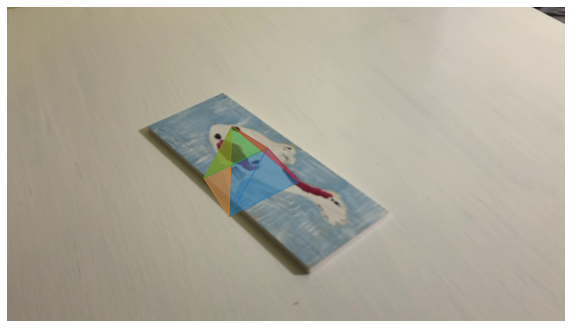

In [18]:
plotPyramid([getProjMatrix(np.eye(3), np.zeros((3,1)), calMatrix)], [im1])

## Triangulate all frames + visualize camera trajectory

In [19]:
imgs_30 = []
for i in range(0, len(imgs), 30):
    imgs_30.append(imgs[i])
print(len(imgs_30))

15


In [20]:
kp_all, des_all = getSIFT(imgs_30)

In [21]:
print(len(imgs_30))
print(len(imgs))

15
449


In [22]:
P = getProjMatrix(np.eye(3), np.zeros((3,1)), calMatrix)
R = np.eye(3)
t = np.zeros((3,1))
Ps = []
Ps.append(P)
points = []
for i in range(len(imgs_30)-1):
    X1in, X2in = getMatches(kp_all[i], des_all[i], kp_all[i+1], des_all[i+1], MATCH_PERCENT=5)
    points3D, _, _, R_, t_ = triangulate(X1in, X2in, calMatrix)
    R = R_@R
    t = R_@t+t_
    P = getProjMatrix(R, t, calMatrix)
    Ps.append(P)
    points.append(points3D)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13


In [23]:
showPlot([points[0]], Ps)

## Insert pyramid into each frame

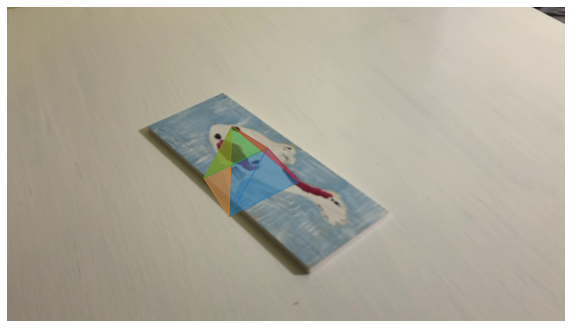

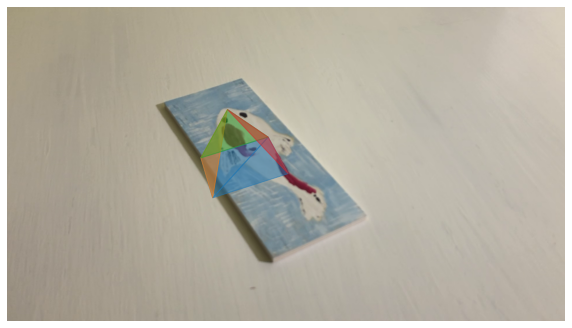

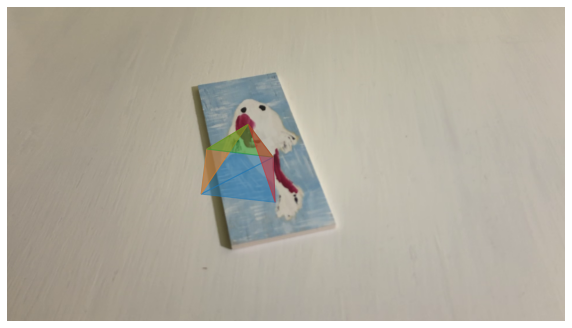

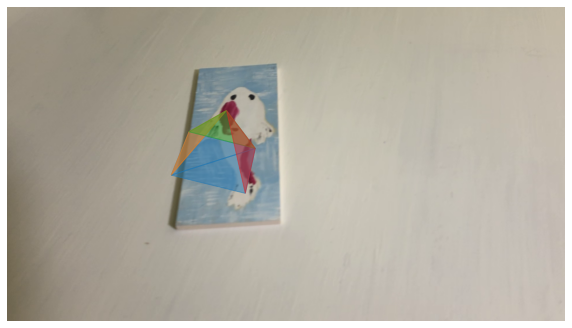

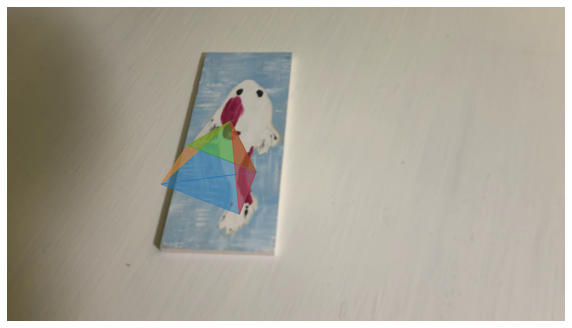

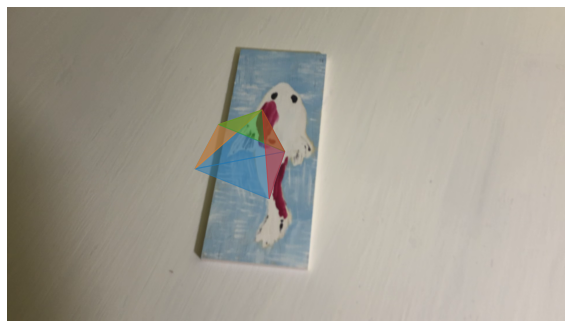

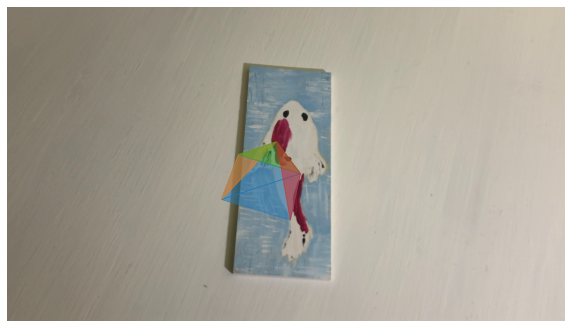

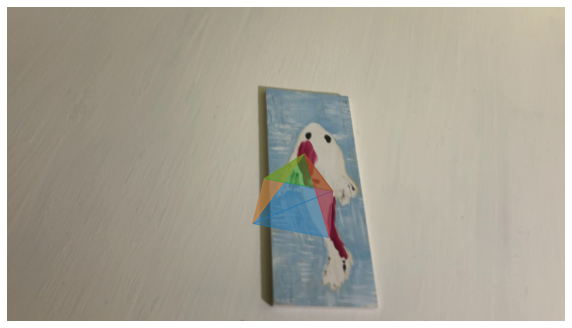

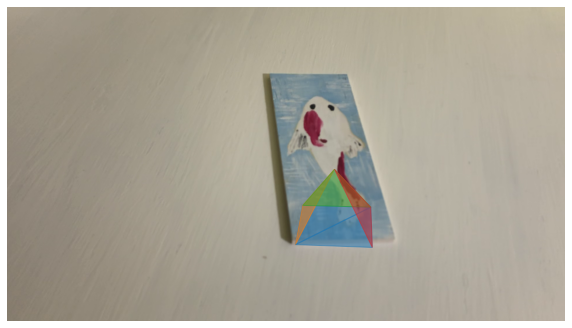

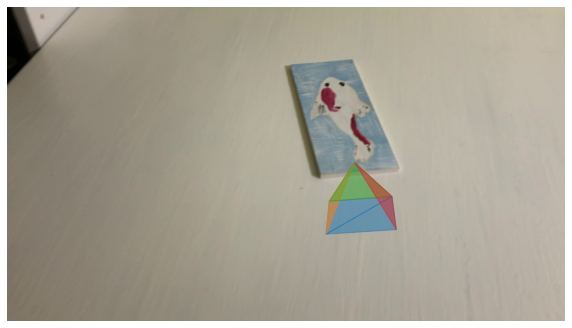

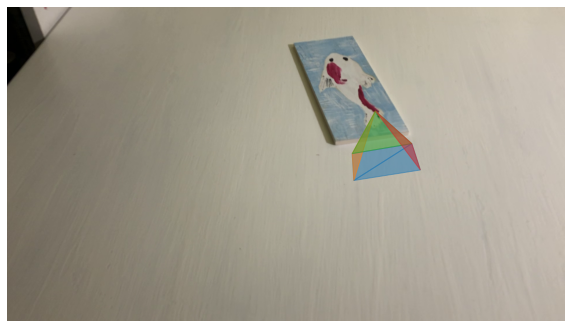

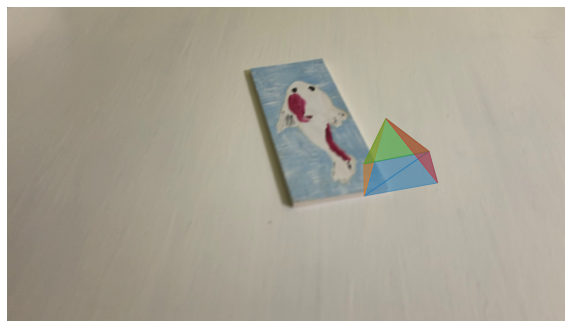

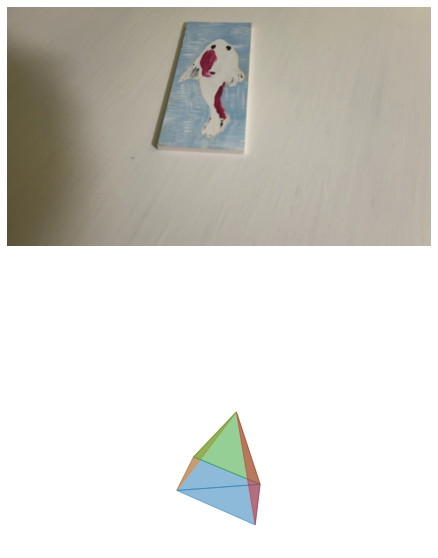

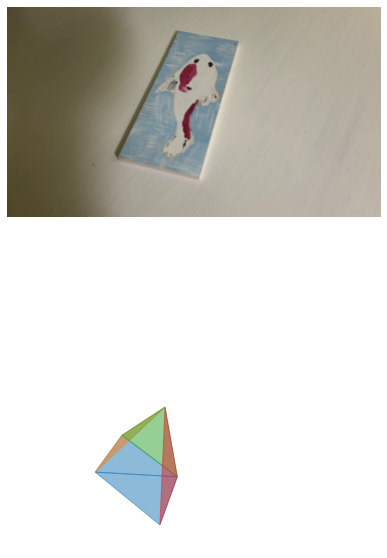

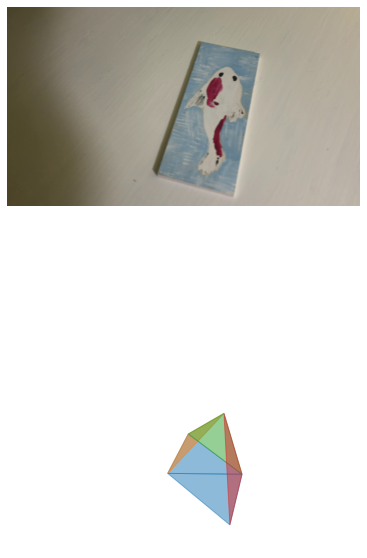

In [24]:
plotPyramid(Ps, imgs_30, makeGIF=True, name='fish_pyramid.gif')